In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from copy import deepcopy as dc


In [13]:

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
ticker = "AAPL"
current_date = datetime.now()
data = yf.download(ticker, start=current_date - timedelta(days=3625), end=current_date, interval="1d")
data = data.reset_index()
data["Date"] = pd.to_datetime(data["Date"])
data = data.drop(columns=["Adj Close"])

def sma(data: pd.DataFrame, period: int):
    data[f"SMA-{period}"] = data["Close"].rolling(window=period).mean()

def std(data: pd.DataFrame, period: int):
    data[f"STD-{period}"] = data["Close"].rolling(window=period).std()

def bb(data: pd.DataFrame, period: int):
    data[f'Lower_BB-{period}'] = data[f"SMA-{period}"] - 2 * data[f"STD-{period}"]
    data[f'Upper_BB-{period}'] = data[f"SMA-{period}"] + 2 * data[f"STD-{period}"]

def ema(data: pd.DataFrame, period: int):
    data[f"EMA-{period}"] = data["Close"].ewm(span=period, adjust=False).mean()

def rsi(data: pd.DataFrame, period: int):
    delta = data["Close"].diff()
    delta = delta.dropna()

    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0], loss[loss > 0] = 0, 0

    avg_gain = gain.ewm(com=14, min_periods=period).mean()
    avg_loss = abs(loss.ewm(com=14, min_periods=period).mean())

    data[f"RSI-{period}"] = 100 - (100 / (1 + (avg_gain / avg_loss)))

period = 20
sma(data, period)
std(data, period)
bb(data, period)
ema(data, period)
rsi(data, period)


[*********************100%%**********************]  1 of 1 completed


In [14]:

# Removing unnecessary features
features = data.columns.tolist()
features.remove("Open")
features.remove("Close")
features.append("Close")

# Selecting features
data = data.dropna()
data = data[features]
data = data.set_index("Date")
data["Close"] = data["Close"].shift(-1)
data = data.iloc[:-1]
data = data.to_numpy()
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)


In [15]:

# CNN Model Definition
class CNN(nn.Module):
    def __init__(self, num_features):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * (num_features // 4), 50)
        self.fc2 = nn.Linear(50, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

num_of_features = X.shape[1]
model = CNN(num_of_features).to(device)

X = data[:, 1:]
y = data[:, 0]

X.shape, y.shape
split_index = int(len(X) * 0.75)

# Splitting the data
X_train, X_test = np.array(X[:split_index]), np.array(X[split_index:])
y_train, y_test = np.array(y[:split_index]), np.array(y[split_index:])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Reshaping the data for CNN
X_train = X_train.reshape((-1, 1, num_of_features))
X_test = X_test.reshape((-1, 1, num_of_features))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train = torch.tensor(X_train, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
y_test = torch.tensor(y_test, device=device).float()


Epoch: 1
Batch 100, Loss: 0.107

Val Loss: 0.020
***************************************************

Epoch: 2
Batch 100, Loss: 0.001

Val Loss: 0.009
***************************************************

Epoch: 3
Batch 100, Loss: 0.001

Val Loss: 0.005
***************************************************

Epoch: 4
Batch 100, Loss: 0.000

Val Loss: 0.004
***************************************************

Epoch: 5
Batch 100, Loss: 0.000

Val Loss: 0.004
***************************************************

Epoch: 6
Batch 100, Loss: 0.000

Val Loss: 0.004
***************************************************

Epoch: 7
Batch 100, Loss: 0.000

Val Loss: 0.004
***************************************************

Epoch: 8
Batch 100, Loss: 0.000

Val Loss: 0.003
***************************************************

Epoch: 9
Batch 100, Loss: 0.000

Val Loss: 0.004
***************************************************

Epoch: 10
Batch 100, Loss: 0.000

Val Loss: 0.003
********************************

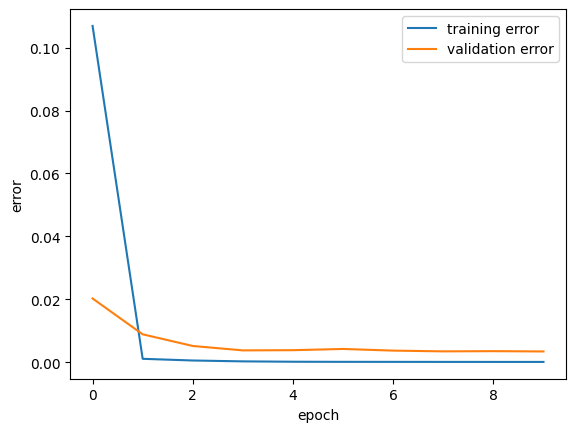

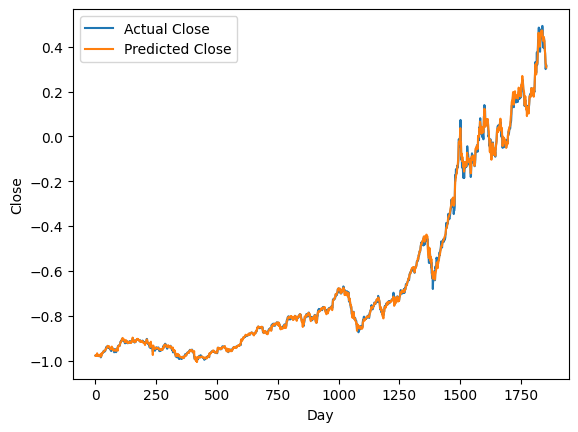

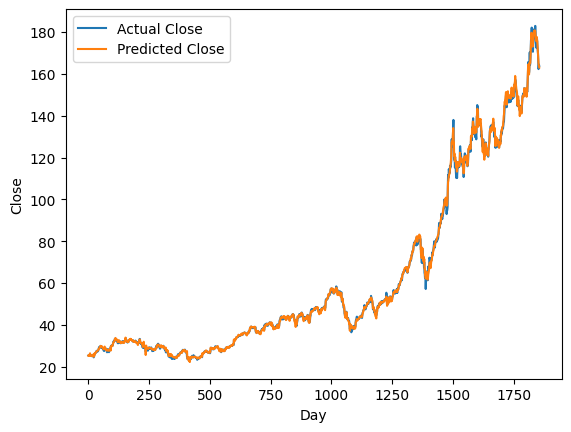

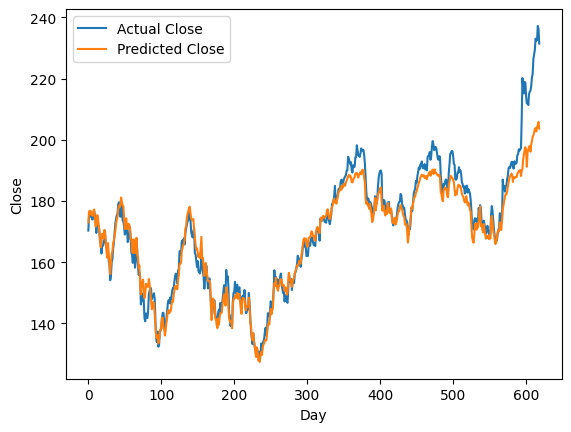

AAPL Stock Prices

Stock Price Now:  224.18
Predicted Stock Price:  203.68
Mean Squared Error on Test Data:  0.00


In [16]:

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []

def train_one_epoch(epoch):
    model.train(True)
    running_loss = 0.0
    print(f'Epoch: {epoch + 1}')

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print(f'Batch {batch_index + 1}, Loss: {avg_loss_across_batches:.3f}')
            train_losses.append(avg_loss_across_batches)
            running_loss = 0.0
    print()

def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    val_losses.append(avg_loss_across_batches)
    print(f'Val Loss: {avg_loss_across_batches:.3f}')
    print('***************************************************')
    print()

learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(epoch)
    validate_one_epoch()

plt.plot(train_losses, label="training error")
plt.plot(val_losses, label="validation error")
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()
plt.show()

with torch.no_grad():
    predicted = model(X_train).to('cpu').numpy()

plt.plot(y_train.cpu(), label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], num_of_features + 1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])

dummies = np.zeros((X_train.shape[0], num_of_features + 1))
dummies[:, 0] = y_train.cpu().flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])

plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], num_of_features + 1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])

dummies = np.zeros((X_test.shape[0], num_of_features + 1))
dummies[:, 0] = y_test.cpu().flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

predicted_price = test_predictions[-1]

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
    predictions_np = predictions.detach().cpu().numpy()
    return mean_squared_error(y_test.cpu(), predictions_np)

mse = evaluate_model(model, X_test, y_test)

def get_current_price(symbol):
    todays_data = yf.Ticker(symbol).history(period='1d')
    return todays_data['Close'].iloc[0]

current_price = get_current_price(ticker)
print(f'{ticker} Stock Prices')
print(f'\nStock Price Now: {current_price: 0.2f}')
print(f'Predicted Stock Price: {predicted_price: 0.2f}')
print(f'Mean Squared Error on Test Data: {mse: 0.2f}')
